In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare the dataset

### Get Label dataset

In [ ]:
import pandas as pd
data_labels = pd.read_csv("/content/drive/MyDrive/Zindi Dataset/Train.csv")

In [ ]:
data_labels.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


### Get Image dataset

In [ ]:
import zipfile

# unzip the downloaded data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Zindi Dataset/road_segment.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# inspect the data
!ls /content/Images

ls: cannot access '/content/Images': No such file or directory


In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
batch_size = 32
image_folder_path = "/content/Images"

## Convert image to jpg and create the label folder

In [ ]:
import os
from PIL import Image
import tensorflow as tf

# create output folder for jpg
output_folder = "/content/new_JPG_images/"

for filename in os.listdir(image_folder_path):
  # ignore .DS_Store
  if filename == '.DS_Store':
    continue
  # Convert TIFF images to JPG format
  else:
    name = os.path.splitext(filename)[0]
    if name in data_labels.values:
      # get the label with Image_ID from csv [TRAIN] dataset
      index_name = data_labels.loc[data_labels['Image_ID'] == name]
      label = index_name["Target"].values[0]

      # get tif image
      im = Image.open('/content/Images/' + filename)
      # Create the output folder based on image's label if it doesn't exist
      os.makedirs(output_folder + str(label), exist_ok=True)
      # save the converted jpg image
      im.save(output_folder + str(label) + "/" + name + '.jpg')

In [ ]:
# get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(output_folder)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['0', '1'], dtype='<U1')

## Visualize the images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup the target directory
  target_folder = target_dir + "/" + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # get 1
  print(random_image)

  # read the image and plot it
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape: {img.shape}")
  return img

['ID_OMpL1yF0.jpg']
Image Shape: (250, 250, 3)


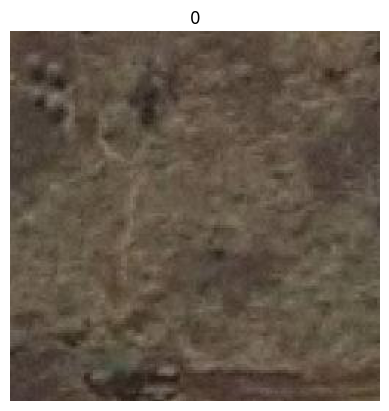

In [ ]:
# visualize
import random
img = view_random_image(target_dir = "/content/new_JPG_images",
                        target_class = random.choice(class_names))

## Preprocess the dataset

In [ ]:
# set data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_DIR = "/content/new_JPG_images"

train_data = image_dataset_from_directory(IMG_DIR,
                                          validation_split = 0.2,
                                          seed = 1,
                                          subset = "training",
                                          label_mode = "binary",
                                          batch_size = BATCH_SIZE,
                                          image_size = (250, 250))

test_data = image_dataset_from_directory(IMG_DIR,
                                          validation_split = 0.2,
                                          seed = 1,
                                          subset = "validation",
                                          label_mode = "binary",
                                          batch_size = BATCH_SIZE,
                                          image_size = (250, 250))

Found 7000 files belonging to 2 classes.
Using 5600 files for training.
Found 7000 files belonging to 2 classes.
Using 1400 files for validation.


## Data augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.1),
    preprocessing.RandomWidth(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomRotation(0.1),
    preprocessing.Rescaling(1./255),
], name = "data_augmentation")

## Build a Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D

# setup input shape
input_shape = (250, 250, 3)

inputs = layers.Input(shape = input_shape, name = "input_layer")
# apply data augmentation layer
x = data_augmentation(inputs)

x = Conv2D(32,(5,5),input_shape=input_shape,activation="relu",padding='same',strides=1)(x)
x = BatchNormalization()(x)
x = AveragePooling2D()(x)

x = Conv2D(64,(3,3),strides=1,activation="relu",padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D()(x)

x = Conv2D(128,(3,3),strides=1,activation="relu",padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D()(x)

x = Conv2D(256,(2,2),strides=1,activation="relu",padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)


outputs = layers.Dense(1, activation = "sigmoid", name = "output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

### Set the optimizer

In [ ]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(learning_rate = 0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# compile the model
model_1.compile(loss = "binary_crossentropy",
                optimizer = optimizer,
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    2432      
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, None, None, 32)   0         
 ooling2D)                                                       
                                                             

### Model Checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy',
                             mode='max', verbose=1,
                             save_best_only=True, period=1)

### Learning rate reducer

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy",
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [ ]:
# fit the model
model_1.fit(train_data,
            epochs = 30,
            validation_data = test_data,
            validation_steps = len(test_data),
            callbacks=[checkpoint, learning_rate_reduction])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.6721
Epoch 1: val_accuracy improved from -inf to 0.50357, saving model to model.h5
175/175 [==============================] - 272s 1s/step - loss: 0.6215 - accuracy: 0.6721 - val_loss: 0.9058 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7125
Epoch 2: val_accuracy improved from 0.50357 to 0.57714, saving model to model.h5
175/175 [==============================] - 188s 1s/step - loss: 0.5736 - accuracy: 0.7125 - val_loss: 0.6909 - val_accuracy: 0.5771 - lr: 0.0010
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.7257
Epoch 3: val_accuracy did not improve from 0.57714
175/175 [==============================] - 160s 909ms/step - loss: 0.5509 - accuracy: 0.7257 - val_loss: 2.4278 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 4/30
175/175 [==============================] - ETA: 0s - 

In [ ]:
# load the best model
loaded_model = tf.keras.models.load_model("/content/model_0.86500.h5")

In [ ]:
loaded_model.evaluate(test_data)

44/44 [==============================] - 2s 33ms/step - loss: 0.3247 - accuracy: 0.8650


[0.3247052729129791, 0.8650000095367432]

In [ ]:
# download model
from google.colab import files
files.download("/content/model_0.86500.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>